In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('ggplot')

## Importing Data

In [2]:
df = pd.read_csv("D:\\DataSets\\uber\\Uber_Request_Data.csv")

In [3]:
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


## Cleaning Data

In [4]:
def fix_columns(df):
    """
    returns column names in standard format
    """
    old_col = df.columns
    new_col = old_col.str.replace(' ', '_').str.lower()
    
    for old, new in zip(list(old_col), list(new_col)):
        df = df.rename(columns={old: new})
        
    return df

In [5]:
# clean and display column names
df = fix_columns(df)
df.columns

Index(['request_id', 'pickup_point', 'driver_id', 'status',
       'request_timestamp', 'drop_timestamp'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
request_id           6745 non-null int64
pickup_point         6745 non-null object
driver_id            4095 non-null float64
status               6745 non-null object
request_timestamp    6745 non-null object
drop_timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB


In [7]:
# Finding number of NA values in each column
print("Number of NA values in each column.")
df.isna().sum()

Number of NA values in each column.


request_id              0
pickup_point            0
driver_id            2650
status                  0
request_timestamp       0
drop_timestamp       3914
dtype: int64

In [8]:
# Dropping redundant columns
df.drop(['request_id', 'driver_id'], axis=1, inplace=True)

## Feature Engineering / Deriving New Metrics

In [9]:
# Converting date-strings to timestamp
df['request_timestamp'] = pd.to_datetime(df['request_timestamp'], dayfirst=True)
df['drop_timestamp'] = pd.to_datetime(df['drop_timestamp'], dayfirst=True)
# Derived metrics
df['request_day'] = df['request_timestamp'].dt.day
df['request_month'] = df['request_timestamp'].dt.month
df['request_hour'] = df['request_timestamp'].dt.hour

df['is_success'] = 0   # Column Indicating whether trip was successfully booked and completed
df.loc[df.status == 'Trip Completed', 'is_success'] = 1

df['time_taken'] = (df['drop_timestamp'] - df['request_timestamp']).astype('timedelta64[m]')

In [10]:
df.head()

,pickup_point,status,request_timestamp,drop_timestamp,request_day,request_month,request_hour,is_success,time_taken
0,Airport,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,11,7,11,1,69.0
1,Airport,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,11,7,17,1,50.0
2,City,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,12,7,9,1,41.0
3,Airport,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,12,7,21,1,55.0
4,City,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,13,7,8,1,52.0


## Exploratory Data Analysis

### Frequency of Trip Statuses

In [11]:
print(f"Data is available for:-\nmonth: {df['request_month'].unique()}\ndays: {df['request_day'].unique()}\nfor the year of {df['request_timestamp'].dt.year.unique()[0]}")

Data is available for:-
month: [7]
days: [11 12 13 14 15]
for the year of 2016


In [12]:
print(f"Drop timestamp is not available only when status is: {df[df['drop_timestamp'].isna()]['status'].unique()}")

Drop timestamp is not available only when status is: ['Cancelled' 'No Cars Available']


In [13]:
df['status'].unique()

array(['Trip Completed', 'Cancelled', 'No Cars Available'], dtype=object)

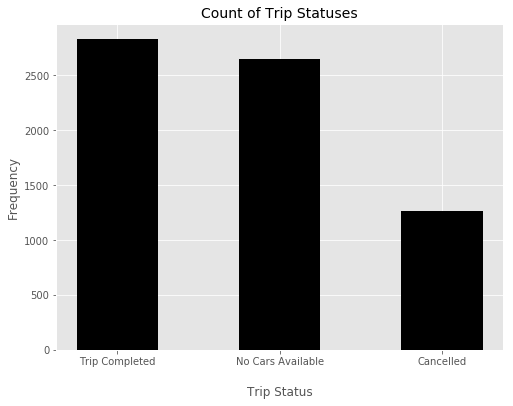

In [14]:
plt.figure(figsize=(8, 6))
x = ['Trip Completed', 'No Cars Available', 'Cancelled']
y = list(df["status"].value_counts())
plt.bar(x, y, width=0.5, color='k')
plt.title("Count of Trip Statuses", fontsize=14)
plt.xlabel("\nTrip Status", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

### Demand-Supply Comparision Seggregated by Day and Hour

In [15]:
def demand_supply_comp(pickup_point):
    pickup_df = df[df["pickup_point"] == pickup_point]
    
    plt.figure(figsize=(12, 6))

    x = ['11th', '12th', '13th', '14th', '15th']
    y = list(pickup_df['request_day'].value_counts())
    y2 = list(pickup_df[pickup_df["is_success"] == 1]['request_day'].value_counts())
    plt.bar(x, y, width=0.5, alpha=0.6)
    plt.bar(x, y2, width=0.2, alpha=0.6)
    plt.legend(['demand', 'supply'])
    plt.title(f"Demand-Supply Seggregated by day at {pickup_point}", fontsize=14)
    plt.ylabel('Requests', fontsize=12)
    plt.show()

    plt.figure(figsize=(16, 8))
    pickup_df['request_hour'].hist(bins=24, alpha=0.6)
    pickup_df[(pickup_df['status'] == 'Trip Completed')]['request_hour'].hist(bins=24, alpha=0.6)
    plt.xticks(np.arange(0, 24, 1.0))
    plt.title(f"\n\nDemand-Supply Seggregated by Hour at {pickup_point}", fontsize=14)
    plt.ylabel('Requests', fontsize=12)
    plt.legend(['demand', 'supply'])
    plt.show()

### At Request Location: Airport

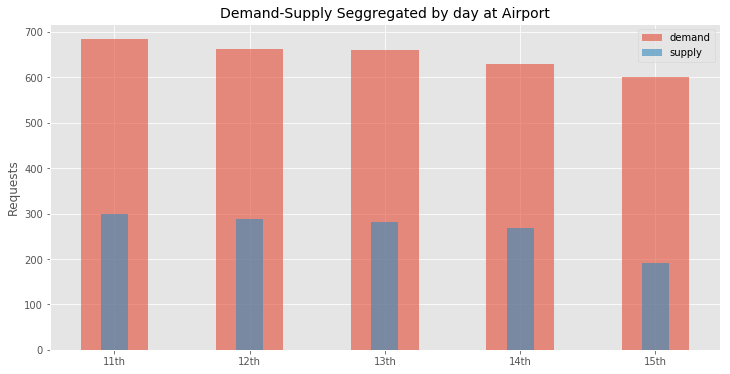

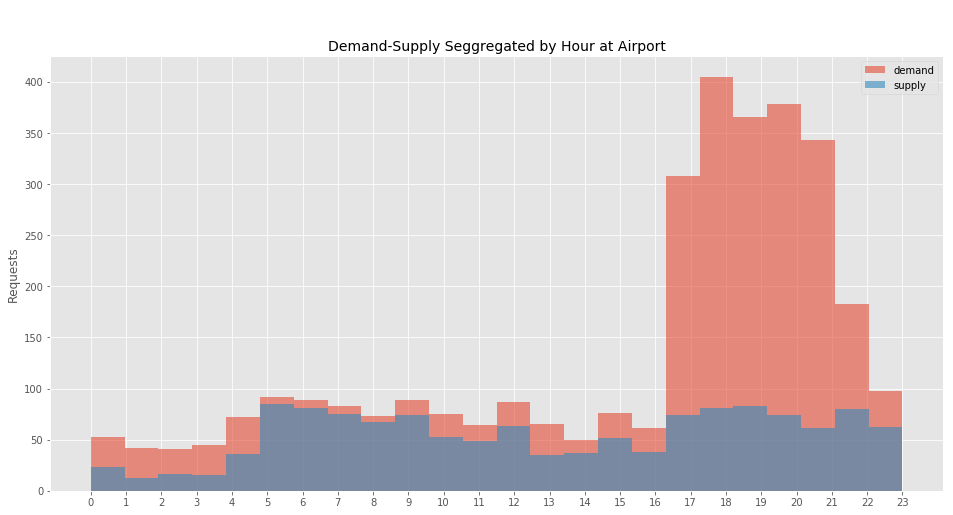

In [16]:
demand_supply_comp("Airport")

Here we can see that the demand for cabs at the airport surges around __4:30pm__ and this surge lasts till __11:00pm__

### At Request Location: City

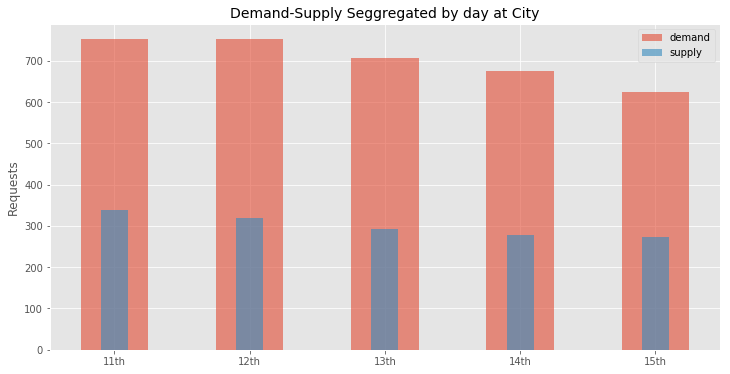

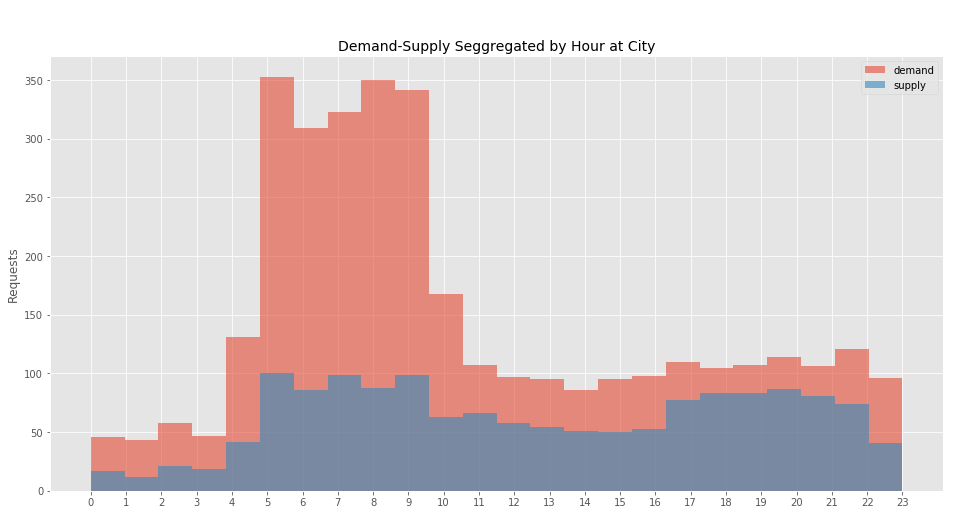

In [17]:
demand_supply_comp("City")

For city-to-Airport travel, demand rises around __4:00am__, and the subsides by __11:00am__

### Comparison of "Cancelled" and "No Cars" segregated by Day and Hour 

In [18]:
def status_comp(df=df[df["is_success"] == 0]):
    
    plt.figure(figsize=(12, 6))

    x = ['11th', '12th', '13th', '14th', '15th']
    y = list(df['request_day'].value_counts())
    y2 = list(df[df["status"]=='No Cars Available']['request_day'].value_counts())
    plt.bar(x, y, width=0.3, color='k', alpha=0.8)
    plt.bar(x, y2, width=0.3, color='g', alpha=0.5)
    plt.ylabel("Requests", fontsize=12)
    plt.title("Seggregated by Day", fontsize=14)
    plt.legend(["Cancelled", "No Cars Available"])
    
    for a,b,c in zip(x, y, y2):
        plt.text(a, c - 200, str(b), horizontalalignment='center', fontsize=15, color='w')
        plt.text(a, b - 150, str(b-c), horizontalalignment='center', fontsize=15, color='w')
    
    
    plt.tight_layout()
    plt.show()

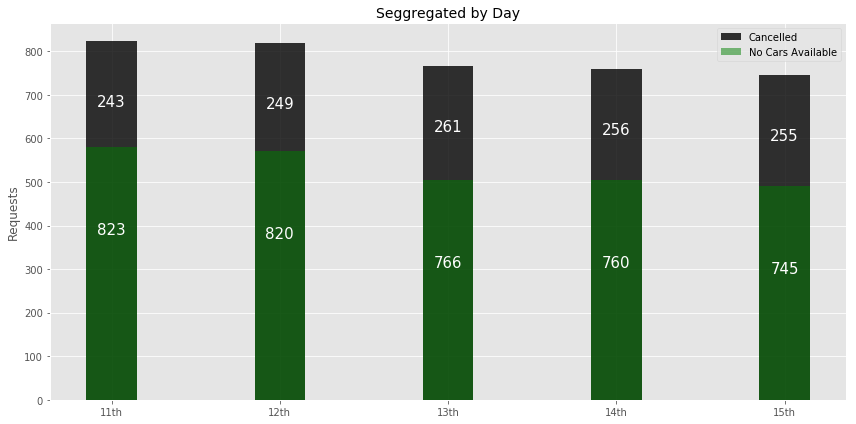

In [19]:
status_comp()

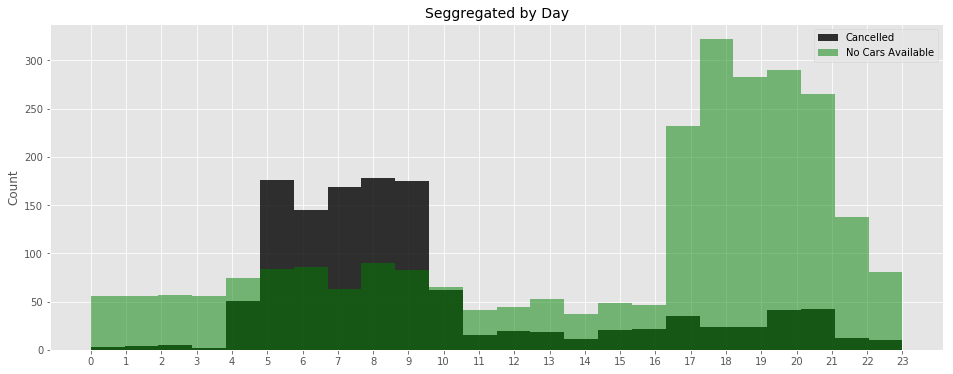

In [23]:
plt.figure(figsize=(16, 6))
df[df['status'] == 'Cancelled']['request_hour'].hist(bins=24, alpha=0.8, color='k')
df[df['status'] == 'No Cars Available']['request_hour'].hist(bins=24, alpha=0.5, color='g')
plt.xticks(np.arange(0, 24, 1.0))
plt.title("Seggregated by Day", fontsize=14)
plt.ylabel("Count")
plt.legend(["Cancelled", "No Cars Available"])
plt.savefig("plot.jpg", orientation="Landscape")
plt.show()



Typically, frequency of cancellations are high between __4:00am__ and __10:00am__, while frequency of a lack of cabs is high between __4:30pm__ and __11:00pm__

## Inferences and Conclusion

Highest demand for travel from City to Airport is between __4:00AM to 11:00AM__ (*Early-Morning to Late-Morning*). During this period we see the most number of  unfulfilled requests due to cab cancellation by the drivers. This is because although there are a lot of available cabs, no cab driver wants to travel to the airport. This is very likely due to the fact that the driver does not wish to return from airport to city without a customer.

On the other hand, highest demand for travel from Airport to City is between __4:30AM to 11:00PM__ (*Evening to Late-Night*). During this period we see most number of unfulfilled requests due to no cabs being available.

## Possible Solutions

<li> Award incentives to drivers during peak-time. This may result in a bit of decrease in demand due to higher pricing of the fare, but net revenue will increase. 
    
<li> Increase awareness among drivers about untapped potential in certain brackets of time where demand is still not being fullfilled



In [21]:
# Exporting data to use in Tableau
df.to_csv("D:\\DataSets\\uber\\Uber_Request_Data2.csv")